1. **Import packages**

In [24]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib as mp
import statsmodels.api as sm
import pmdarima as pm
import time
from datetime import datetime, timedelta
from scipy import stats
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb        #JZ
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import argparse

2. **Load data into pandas dataframe**

In [2]:
masterdf=pd.read_csv('data//CMaster2_HPS_CDC_CPS_Vaccinated_with_lock.csv')

In [3]:
masterdf.info()
masterdf.head()
#masterdf['MONTH'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131705 entries, 0 to 3131704
Data columns (total 27 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   field1                               int64  
 1   YMFIPS                               object 
 2   YEAR                                 int64  
 3   MONTH                                object 
 4   FIPS                                 int64  
 5   STATE_C                              object 
 6   LOCATION                             object 
 7   TBIRTH_YEAR                          int64  
 8   EEDUC                                int64  
 9   THHLD_NUMPER                         int64  
 10  THHLD_NUMKID                         int64  
 11  THHLD_NUMADLT                        int64  
 12  WRKLOSS                              int64  
 13  KINDWORK                             int64  
 14  ANXIOUS                              int64  
 15  WORRY                           

,field1,YMFIPS,YEAR,MONTH,FIPS,STATE_C,LOCATION,TBIRTH_YEAR,EEDUC,THHLD_NUMPER,...,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,lockdown
0,0,2021-9-01,2021,SEP,1,AL,Alabama,1941,7,1,...,-88,-88,4,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
1,1,2021-9-01,2021,SEP,1,AL,Alabama,1973,4,3,...,1,4,6,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
2,2,2021-9-13,2021,SEP,13,GA,Georgia,1970,4,1,...,1,3,1,0.043,58816.0,5828605.0,54.90,4823331.0,45.43,0
3,3,2021-9-01,2021,SEP,1,AL,Alabama,1969,3,6,...,-88,-88,-88,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0
4,4,2021-9-01,2021,SEP,1,AL,Alabama,1977,4,3,...,-88,-88,-88,0.032,44878.0,2583590.0,52.69,2089852.0,42.62,0


3. **Clean data**

* Convert year month fips field to datetime datatype

In [4]:
m_n={'JAN':1, 'FEB':2, 'MAR':3, 'APR':4,'MAY':5,'JUN':6, 'JUL':7, 'AUG':8,'SEP':9, 'OCT':10,'NOV':11, 'DEC':12}
masterdf['MONTH'] = masterdf['MONTH'].apply(lambda i: m_n[i])
masterdf['YEARMONTH']=masterdf['YEAR'].astype('str')+'-'+masterdf['MONTH'].astype('str')
#masterdf['YEARMONTH']=pd.to_datetime(masterdf['YEAR'].astype('str')+'-'+masterdf['MONTH'].astype('str')+'-01')
#print(masterdf.iloc[1])
masterdf.info()
print(masterdf['YEARMONTH'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3131705 entries, 0 to 3131704
Data columns (total 28 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   field1                               int64  
 1   YMFIPS                               object 
 2   YEAR                                 int64  
 3   MONTH                                int64  
 4   FIPS                                 int64  
 5   STATE_C                              object 
 6   LOCATION                             object 
 7   TBIRTH_YEAR                          int64  
 8   EEDUC                                int64  
 9   THHLD_NUMPER                         int64  
 10  THHLD_NUMKID                         int64  
 11  THHLD_NUMADLT                        int64  
 12  WRKLOSS                              int64  
 13  KINDWORK                             int64  
 14  ANXIOUS                              int64  
 15  WORRY                           

* Understand how many records in work loss data element are null. Result is very few, so will just remove record with null wrkloss

In [5]:
masterdf['WRKLOSS'].value_counts()

 2     2102136
 1     1002257
-99      19450
-88       7862
Name: WRKLOSS, dtype: int64

* Given result, we should remove the records with -99/-88 values in WRKLOSS, ANXIOUS, WORRY, DOWN, INCOME

In [6]:
masterdf=masterdf[(masterdf['WRKLOSS'] != -99) & (masterdf['WRKLOSS'] !=-88) &
                  (masterdf['ANXIOUS'] != -99) & (masterdf['ANXIOUS'] !=-88) &
                  (masterdf['WORRY'] != -99) & (masterdf['WORRY'] !=-88) &
                  (masterdf['DOWN'] != -99) & (masterdf['DOWN'] !=-88) &
                  (masterdf['INCOME'] != -99) & (masterdf['INCOME'] !=-88)].reset_index(drop=True)

* Rename some fields, and drop some not needed for modeling

In [7]:
"""def awd_classify(awdnum:int=6)-> int :
    if awdnum <=4:
        awdclass=1
    elif awdnum <=7:
        awdclass=2
    elif awdnum <=10:
        awdclass=3
    else:
        awdclass=4
        
    return(awdclass)
"""

def awd_classify(awdnum:int=6)-> int :
    if awdnum <=7:
        awdclass=0
    else:
        awdclass=1       
    return(awdclass)


#masterdf=masterdf.rename(columns={"people_vaccinated": "VAXXED", "people_fully_vaccinated": "FULLYVAXXED"})

masterdf['ANXWORRYDWN_NUM']=masterdf.ANXIOUS+masterdf.WORRY+masterdf.DOWN
#masterdf['ANXWORRYDWN']=masterdf.apply(lambda row: awd_classify(row['ANXIOUS']+row['WORRY']+row['DOWN']), axis=1)
masterdf['ANXWORRYDWN']=np.where(masterdf['ANXWORRYDWN_NUM']>7, 1, 0)

masterdf=masterdf[['YEARMONTH','STATE_C','TBIRTH_YEAR','EEDUC','WRKLOSS','KINDWORK',
                   'MORTLMTH','MORTCONF','INCOME', 'REMPCT', 'CDCCOUNT', 
                   'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred',
                   'ANXWORRYDWN_NUM','ANXWORRYDWN']].reset_index(drop=True)
                
#masterdf=masterdf.drop(columns=['YMFIPS','YEAR','MONTH','FIPS','STATE','LOCATION','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred'])

In [8]:
print(masterdf.info())
print(masterdf['ANXWORRYDWN'].value_counts())
masterdf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502286 entries, 0 to 2502285
Data columns (total 15 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   YEARMONTH                            object 
 1   STATE_C                              object 
 2   TBIRTH_YEAR                          int64  
 3   EEDUC                                int64  
 4   WRKLOSS                              int64  
 5   KINDWORK                             int64  
 6   MORTLMTH                             int64  
 7   MORTCONF                             int64  
 8   INCOME                               int64  
 9   REMPCT                               float64
 10  CDCCOUNT                             float64
 11  people_vaccinated_per_hundred        float64
 12  people_fully_vaccinated_per_hundred  float64
 13  ANXWORRYDWN_NUM                      int64  
 14  ANXWORRYDWN                          int32  
dtypes: float64(4), int32(1), int64(8

,YEARMONTH,STATE_C,TBIRTH_YEAR,EEDUC,WRKLOSS,KINDWORK,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ANXWORRYDWN_NUM,ANXWORRYDWN
0,2021-9,AL,1941,7,2,-88,-88,-88,4,0.032,44878.0,52.69,42.62,3,0
1,2021-9,AL,1973,4,2,5,1,4,6,0.032,44878.0,52.69,42.62,6,0
2,2021-9,GA,1970,4,1,-88,1,3,1,0.043,58816.0,54.90,45.43,5,0
3,2021-9,AK,1965,4,2,3,-88,-88,7,0.048,7180.0,57.28,50.59,6,0
4,2021-9,AK,1983,7,2,1,-88,4,6,0.048,7180.0,57.28,50.59,3,0


* Profile several fields

In [9]:
print('MORTLMTH values:', masterdf[(masterdf['MORTLMTH']!=-99) & (masterdf['MORTLMTH']!=-88)].shape[0])
print('MORTCONF values:', masterdf[(masterdf['MORTCONF']!=-99) & (masterdf['MORTCONF']!=-88)].shape[0])
print('KINDWORK values:', masterdf[(masterdf['KINDWORK']!=-99) & (masterdf['KINDWORK']!=-88)].shape[0])

masterdf=masterdf[(masterdf['MORTLMTH'] != -99) & (masterdf['MORTLMTH'] !=-88) &
                  (masterdf['MORTCONF'] != -99) & (masterdf['MORTCONF'] !=-88) &
                  (masterdf['KINDWORK'] != -99) & (masterdf['KINDWORK'] !=-88)].reset_index(drop=True)

# find total number of record with null vaxx values
print(masterdf['people_vaccinated_per_hundred'].isna().sum())
print(masterdf['people_fully_vaccinated_per_hundred'].isna().sum())
# backfill null vaxx values with 0
masterdf=masterdf.fillna(0).reset_index(drop=True)

#profile mental state values
print(masterdf['ANXWORRYDWN'].value_counts())

print(masterdf.info())

MORTLMTH values: 1472272
MORTCONF values: 1829379
KINDWORK values: 1464252
649519
649519
0    759582
1    201140
Name: ANXWORRYDWN, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   YEARMONTH                            960722 non-null  object 
 1   STATE_C                              960722 non-null  object 
 2   TBIRTH_YEAR                          960722 non-null  int64  
 3   EEDUC                                960722 non-null  int64  
 4   WRKLOSS                              960722 non-null  int64  
 5   KINDWORK                             960722 non-null  int64  
 6   MORTLMTH                             960722 non-null  int64  
 7   MORTCONF                             960722 non-null  int64  
 8   INCOME                               960722 non-null  int64  
 9   RE

* further edit the  MORTLMTH MORTCONF and KINDWORK data

In [10]:
print(masterdf['MORTLMTH'].value_counts())
print(masterdf['MORTCONF'].value_counts())
print(masterdf['KINDWORK'].value_counts())
print(masterdf['YEARMONTH'].value_counts())

1    893718
2     55842
3     11162
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     23370
5     13300
Name: MORTCONF, dtype: int64
2    529748
1    176385
3    130348
4    106208
5     18033
Name: KINDWORK, dtype: int64
2020-5     153293
2020-6     148335
2020-7     109646
2020-9      82134
2021-9      46280
2020-10     39595
2021-2      37983
2021-3      37920
2020-11     37721
2021-1      37122
2021-4      35515
2021-8      35402
2021-5      34454
2020-4      31180
2021-6      31155
2020-8      28717
2020-12     17922
2021-7      16348
Name: YEARMONTH, dtype: int64


* convert MORTLMTH with values 2 and 3 to 0
* convert MORTCONF with values 5 to 1
* convert KINDWORK to categorical var

In [11]:
#replace values 2 and 3 with 0 (did not pay), existing 1 means paid
masterdf.loc[(masterdf['MORTLMTH'] == 2) | (masterdf['MORTLMTH'] == 3),'MORTLMTH']=0
print(masterdf['MORTLMTH'].value_counts())

#replace values 5 with 1 (did not pay)
masterdf.loc[(masterdf['MORTCONF'] == 5),'MORTCONF']=1
print(masterdf['MORTCONF'].value_counts())

#categorize/onehot the kind of work variable
KINDWORK_onehot = pd.get_dummies(masterdf['KINDWORK'])  
KINDWORK_onehot.rename(columns={1:'Work_Government',2:'Work_Private',3:'Work_NonProfit',4:'Work_SelfEmp',5:'Work_FamilyBiz'},inplace=True)
masterdf = pd.concat([masterdf,KINDWORK_onehot],axis=1)
print(masterdf.info())

1    893718
0     67004
Name: MORTLMTH, dtype: int64
4    733097
3    138318
2     52637
1     36670
Name: MORTCONF, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   YEARMONTH                            960722 non-null  object 
 1   STATE_C                              960722 non-null  object 
 2   TBIRTH_YEAR                          960722 non-null  int64  
 3   EEDUC                                960722 non-null  int64  
 4   WRKLOSS                              960722 non-null  int64  
 5   KINDWORK                             960722 non-null  int64  
 6   MORTLMTH                             960722 non-null  int64  
 7   MORTCONF                             960722 non-null  int64  
 8   INCOME                               960722 non-null  int64  
 9   REMPCT           

* ***Create two dataset, one for the individual level modeling and one for the statewide level***

In [12]:
# drop columns not need for modeling
masterdf.drop(columns=['KINDWORK'],inplace=True)

############################################################################################
# aggregate at the state/month level, then perform the aggregated data set modeling later on
############################################################################################
masterdfagg=masterdf.groupby(['YEARMONTH','STATE_C']).mean().reset_index()
masterdfagg.head(5)


#######################################################################
# main dataset for performing modeling at the individual survey level
#######################################################################
masterdf.drop(columns=['STATE_C','ANXWORRYDWN_NUM', 'YEARMONTH'],inplace=True)
masterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960722 entries, 0 to 960721
Data columns (total 16 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   TBIRTH_YEAR                          960722 non-null  int64  
 1   EEDUC                                960722 non-null  int64  
 2   WRKLOSS                              960722 non-null  int64  
 3   MORTLMTH                             960722 non-null  int64  
 4   MORTCONF                             960722 non-null  int64  
 5   INCOME                               960722 non-null  int64  
 6   REMPCT                               960722 non-null  float64
 7   CDCCOUNT                             960722 non-null  float64
 8   people_vaccinated_per_hundred        960722 non-null  float64
 9   people_fully_vaccinated_per_hundred  960722 non-null  float64
 10  ANXWORRYDWN                          960722 non-null  int32  
 11  Work_Governme

* Look at variance inflation factor

In [13]:
x_sample=masterdf.sample(frac=0.00005, replace=False, random_state=1)

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['ANXWORRYDWN'])]]
print(calc_vif(X))

#X = masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['people_vaccinated_per_hundred','ANXWORRYDWN','Work_Private'])]]
#calc_vif(X)

                              variables           VIF
0                           TBIRTH_YEAR      1.037048
1                                 EEDUC      1.263738
2                               WRKLOSS      1.164638
3                              MORTLMTH      1.346663
4                              MORTCONF      1.503860
5                                INCOME      1.317906
6                                REMPCT      1.204436
7                              CDCCOUNT      1.014591
8         people_vaccinated_per_hundred     31.281098
9   people_fully_vaccinated_per_hundred     31.332042
10                      Work_Government   4947.603876
11                         Work_Private  14875.101144
12                       Work_NonProfit   3656.728662
13                         Work_SelfEmp   2963.666175
14                       Work_FamilyBiz    506.359623


* Run pairwise scatter plot

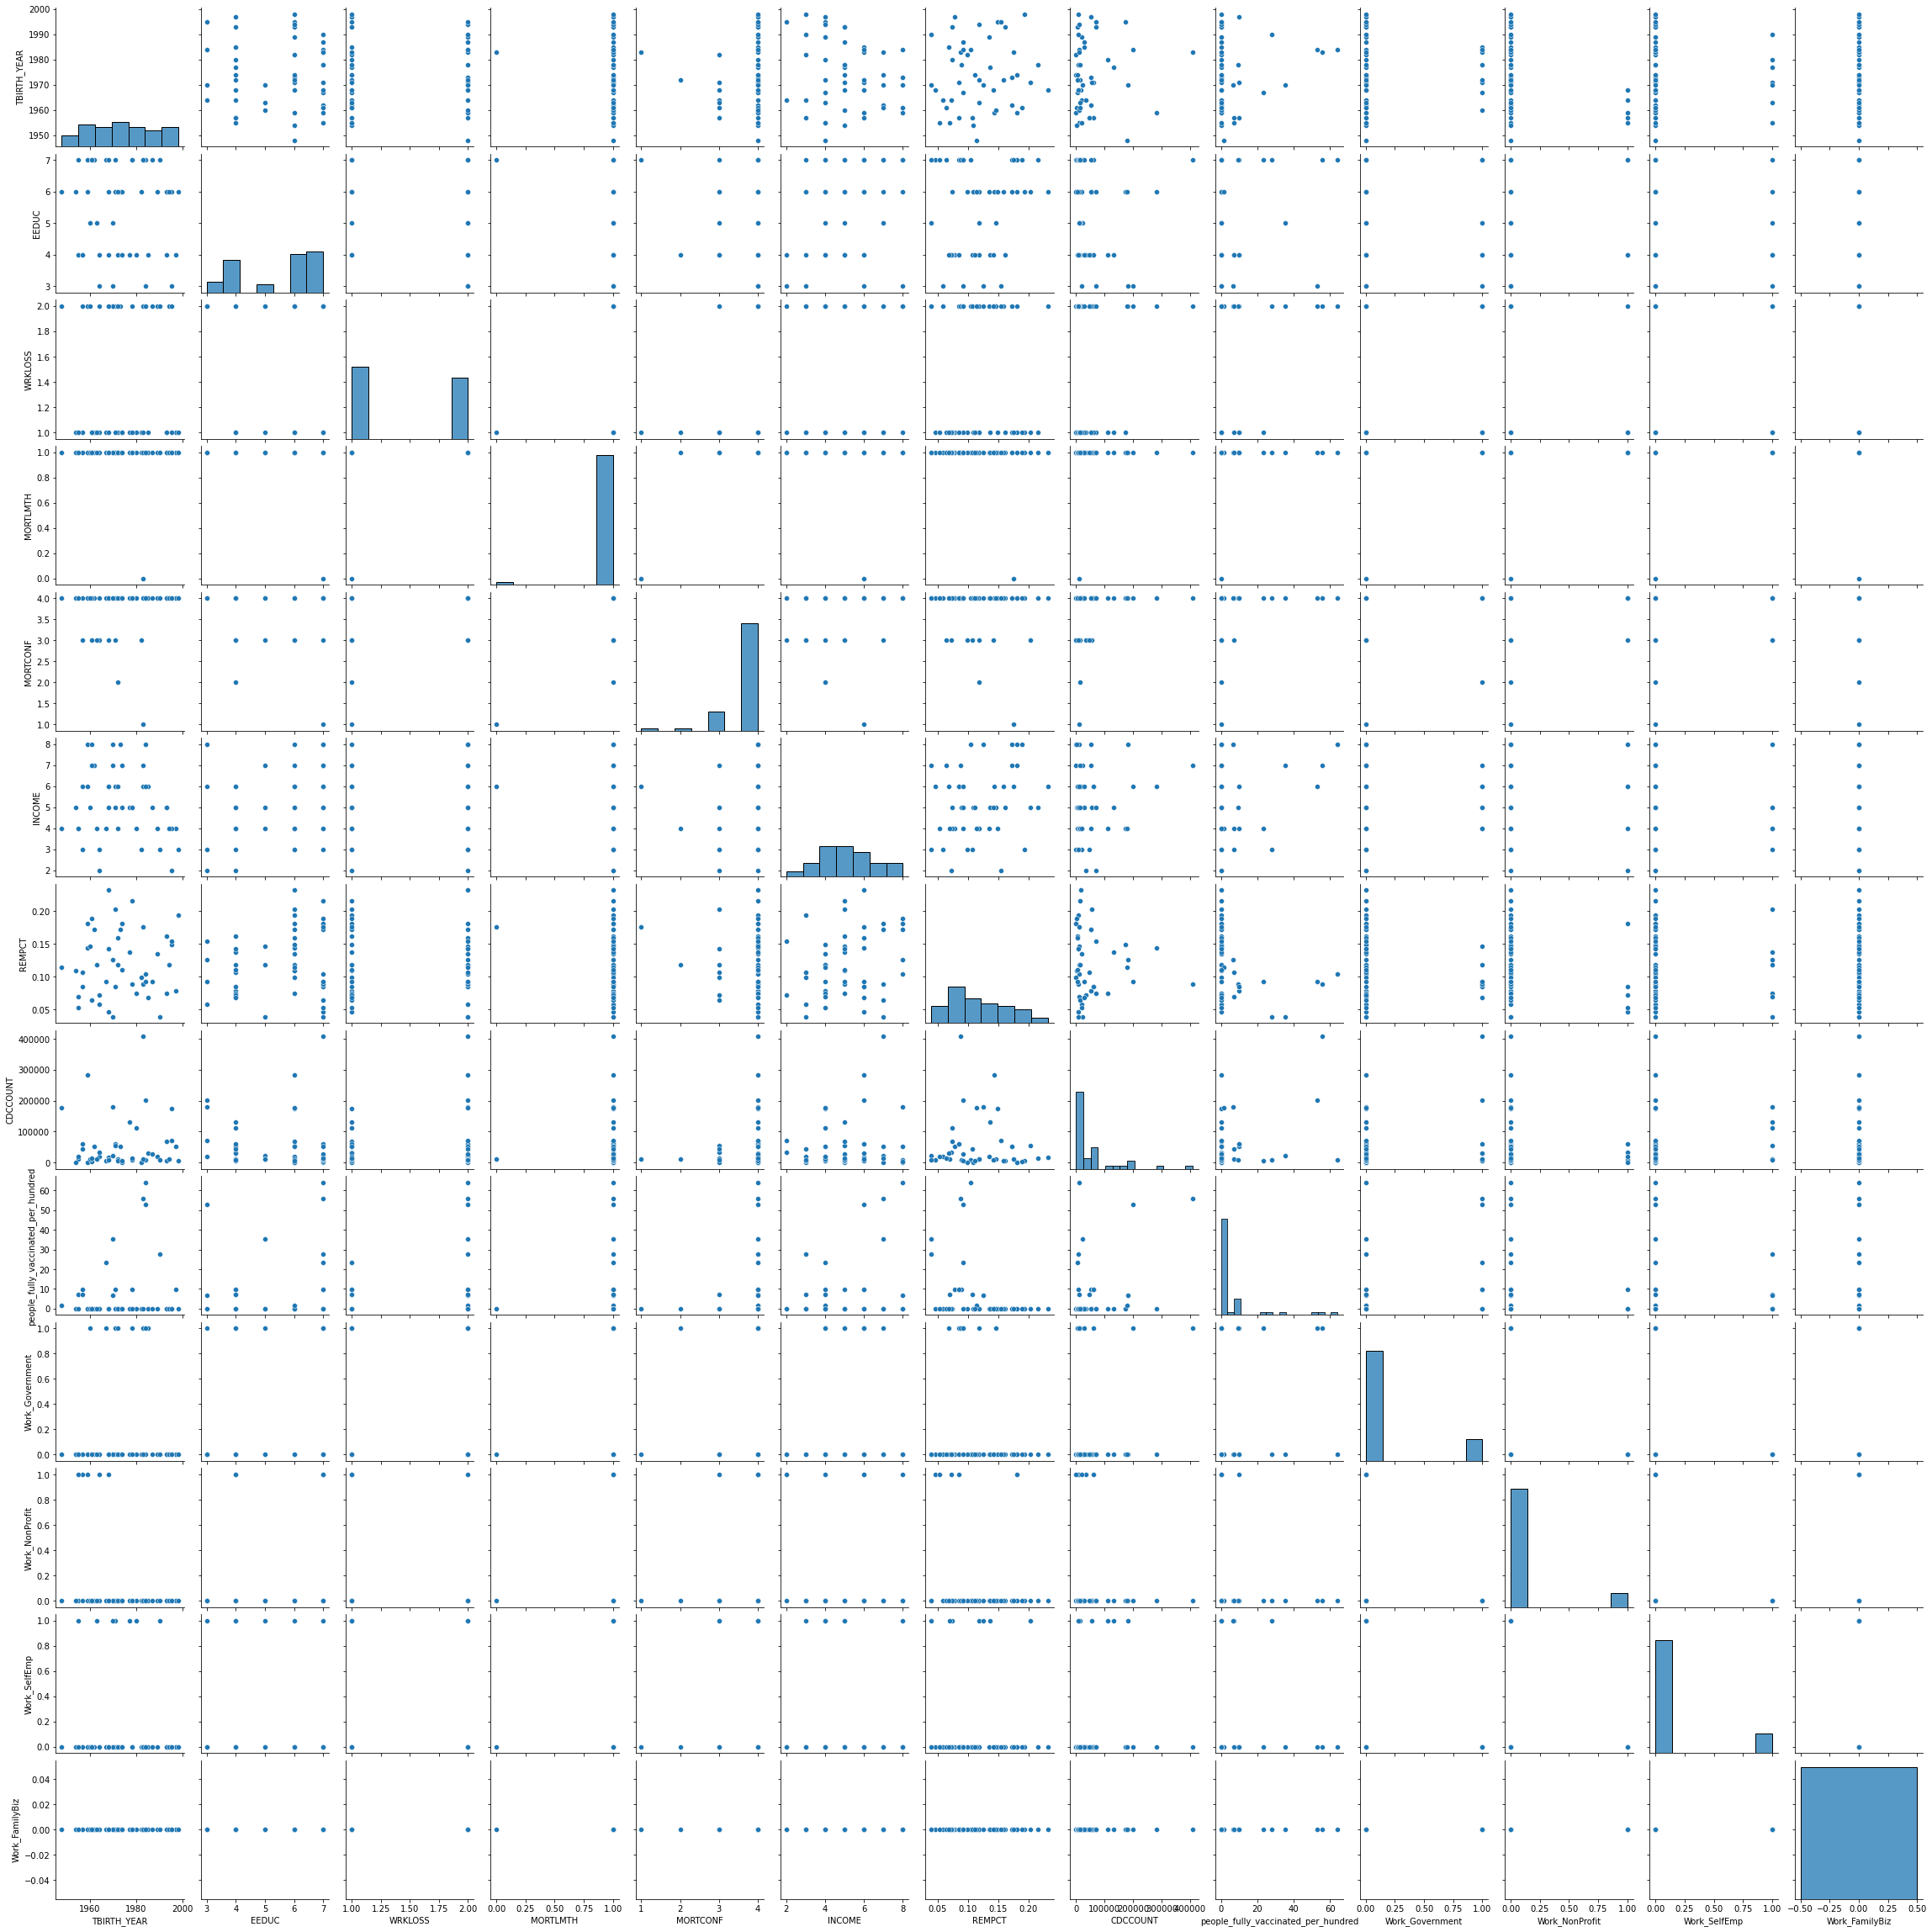

In [14]:
x_sample=masterdf.sample(frac=0.00005, replace=False, random_state=1)

sns.pairplot(x_sample.loc[:,~x_sample.columns.isin(['people_vaccinated_per_hundred','ANXWORRYDWN','Work_Private'])])

* look at correlation

In [15]:
mdfcorr=masterdf.loc[:, masterdf.columns != 'ANXWORRYDWN'].corr()

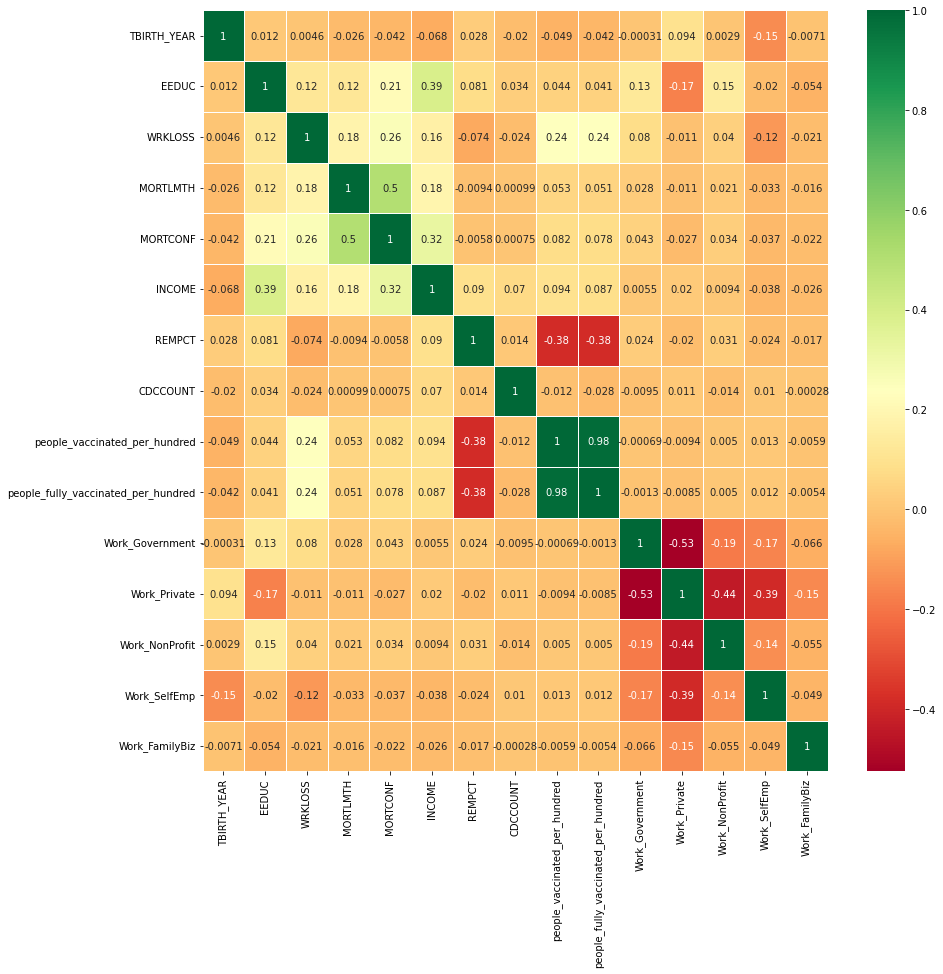

In [16]:
# heatmap plot
plt.figure(figsize=(14,14))
sns.heatmap(mdfcorr,cbar=True,linewidths=.5,yticklabels=True,xticklabels=True,annot=True,cmap="RdYlGn")
plt.show()

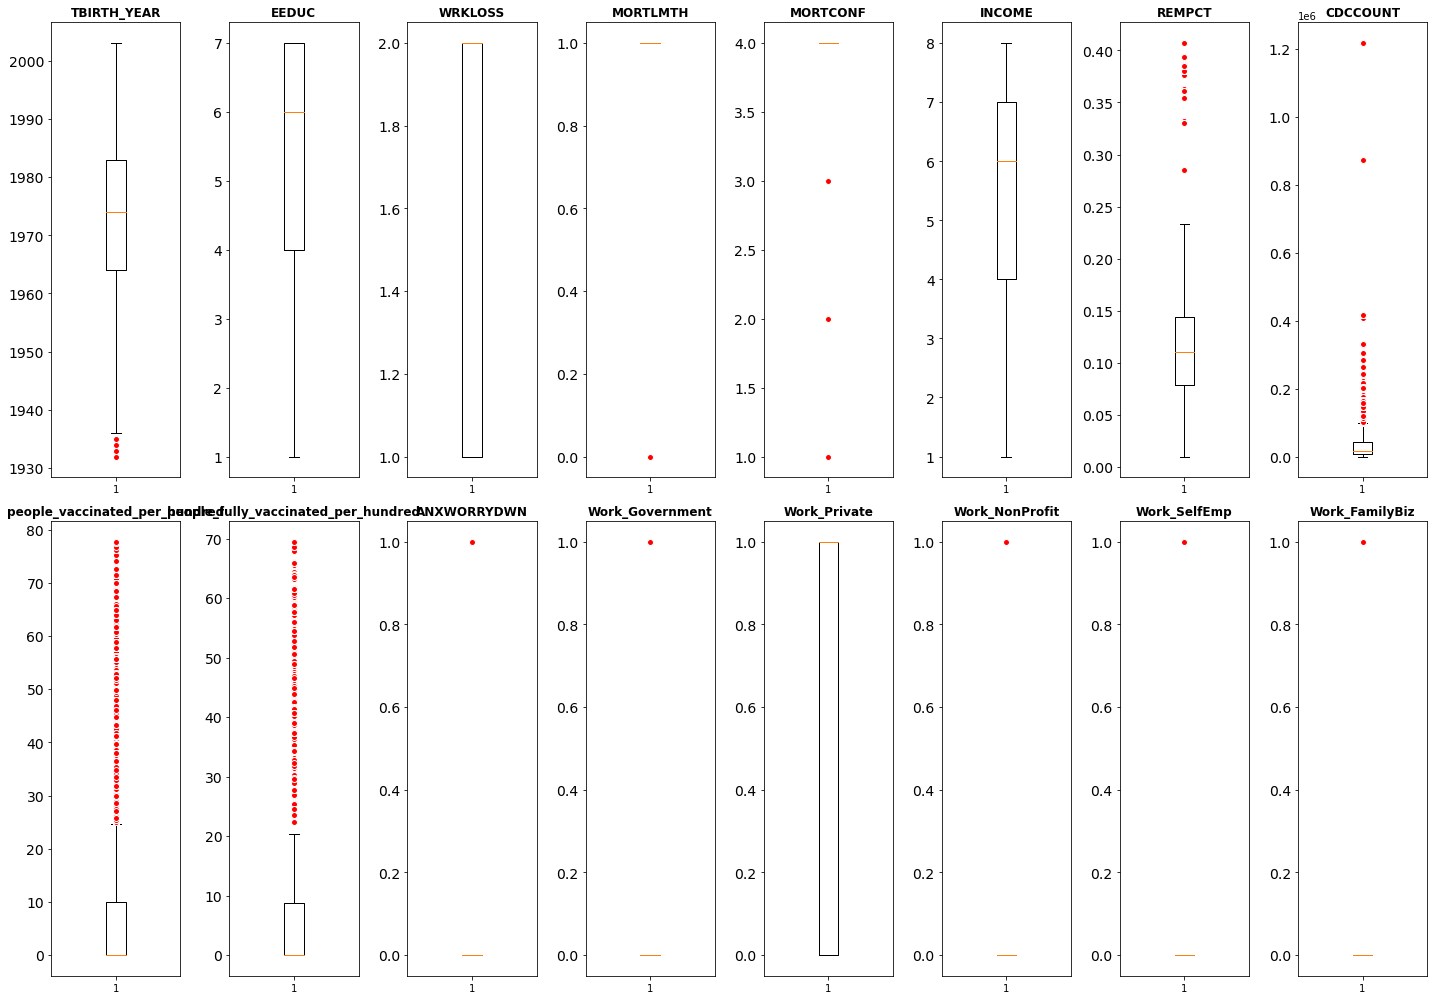

In [17]:
# box whisker plot  boxplot( seaborn and matplotlib)
# masterdf


#Creating subplot of each column with its own scale 
red_circle = dict(markerfacecolor='red' , marker='o', markeredgecolor='white') 
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))
                        
for i, ax in enumerate(axs.flat):
    ax.boxplot(masterdf.iloc[:,i], flierprops=red_circle) 
    ax.set_title(masterdf.columns[i], fontsize=12, fontweight='bold') 
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()




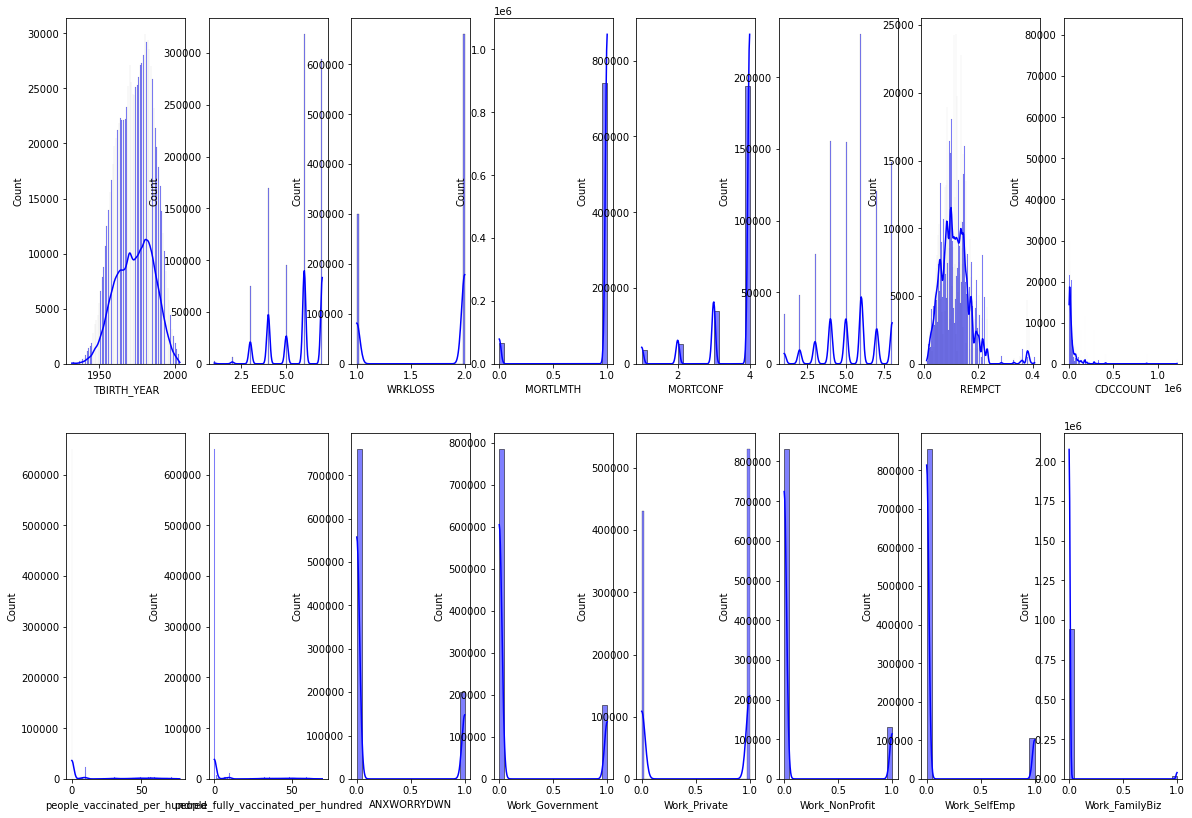

In [18]:
# distribution graph (kernel density estimate (kde) plot shape of dist)
fig, axs = plt.subplots(2, round(len(masterdf.columns)/2), figsize=(20,14))

for i, ax in enumerate(axs.flat):
    #sns.distplot(df[l[i]],kde=True)
    #scores = df.loc[(df['prog'] == prog)]['score']

    # note how I put 'ax' here
    sns.histplot(masterdf.iloc[:,i], kde=True, ax=ax, color='b')

    """# change all the axes into ax
    sigma = round(scores.std(), 3)
    mu = round(scores.mean(), 2)
    ax.set_xlim(1,7)
    ax.set_xticks(range(2,8))
    ax.set_xlabel('Score - Mean: {} (σ {})'.format(mu, sigma))
    ax.set_ylabel('Density')
    """

plt.show()

4. **Performing modeling**

**split data into train test**

In [19]:
#cutoffdate=pd.to_datetime('2021-07-01')
#print(cutoffdate, mindate_w_vax)
#earlyda = mdf_mlm.loc[(mdf_mlm['YEARMONTH']<= cutoffdate) & (mdf_mlm['YEARMONTH']>=mindate_w_vax)]

X_train, X_test, y_train, y_test = train_test_split(
    masterdf.loc[:, masterdf.columns[~masterdf.columns.isin(['ANXWORRYDWN'])]], 
    masterdf['ANXWORRYDWN'], 
    test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(720541, 15)
(240181, 15)


* oversampling for RF model

In [20]:
print(y_train.value_counts())
y_train_awd1idx=y_train[y_train == 1].index
y_train_awd1=y_train[y_train_awd1idx]
y_train_rf=pd.concat([y_train, y_train_awd1, y_train_awd1],ignore_index=True)
print(y_train_rf.value_counts(), len(y_train_rf))

X_train_awd1=X_train.loc[y_train_awd1idx]
X_train_rf=pd.concat([X_train, X_train_awd1, X_train_awd1], ignore_index=True)
print(len(X_train_rf))

0    569760
1    150781
Name: ANXWORRYDWN, dtype: int64
0    569760
1    452343
Name: ANXWORRYDWN, dtype: int64 1022103
1022103


* Deploy xgboost model

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:04:47] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.65617	validation_1-logloss:0.65631
[1]	validation_0-logloss:0.62622	validation_1-logloss:0.62636
[2]	validation_0-logloss:0.60137	validation_1-logloss:0.60171
[3]	validation_0-logloss:0.58086	validation_1-logloss:0.58133
[4]	validation_0-logloss:0.56382	validation_1-logloss:0.56436
[5]	validation_0-logloss:0.54956	validation_1-logloss:0.55019
[6]	validation_0-logloss:0.53766	validation_1-logloss:0.53832
[7]	validation_0-logloss:0.52760	validation_1-logloss:0.52838
[8]	validation_0-logloss:0.51918	validation_1-logloss:0.52001
[9]	validation_0-logloss:0.51208	validation_1-logloss:0.51300
[10]	validation_0-logloss:0.50609	validation_1-logloss:0.50710
[11]	validation_0-logloss:0.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

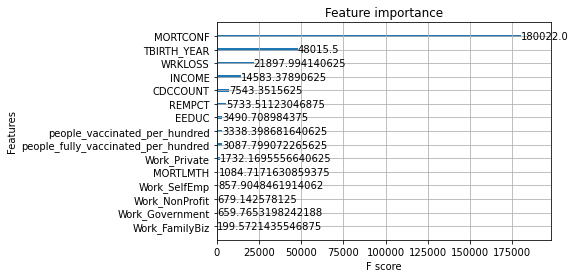

In [21]:
# Set up xg model, fit the model
mdf_xg =XGBClassifier(n_estimators=60,learning_rate=0.1) #optimize?
mdf_xg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], early_stopping_rounds=10, verbose=True)
print(mdf_xg.score(X_test, y_test))
#print(mdf_mlm_xg.evals_result())
feature_importance=mdf_xg.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
print(feature_imp_pd.sort_values(0, ascending=False))

#importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgg=mdf_xg.get_booster().get_score(importance_type='total_gain')
print(xgg)

xgb.plot_importance(mdf_xg,importance_type='total_gain') # jz

In [22]:
# run prediction and evaluate metrics
mdf_xg_p = mdf_xg.predict(X_test)
print(type(mdf_xg_p))

print('XG Accuracy score = ', metrics.accuracy_score(mdf_xg_p, y_test))
print('XG MAE = ', metrics.mean_absolute_error(mdf_xg_p, y_test))
print('XG RMSE = ', metrics.mean_squared_error(mdf_xg_p, y_test, squared=False))

<class 'numpy.ndarray'>
XG Accuracy score =  0.7922275284056607
XG MAE =  0.20777247159433926
XG RMSE =  0.455820657270312


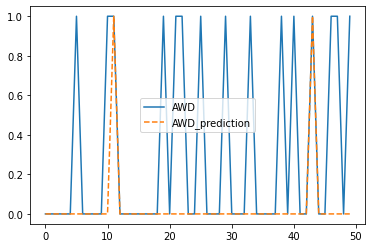

In [23]:
yt=pd.DataFrame(y_test.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdf_xg_p)
#print(ypredict[0:5])
plt.plot(yt[0:50], label = "AWD", linestyle="-")
plt.plot(ypredict[0:50], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()



* save to pickle file

In [26]:
with open('mental_health_xgboost.pickle', 'wb') as handle:
            pickle.dump(mdf_xg, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('mental_health_xgboost.pickle', 'rb') as handle:
            xg_model=pickle.load(handle)

* Deploying random forest model

In [24]:
# Set up RF model, fit the model
mdf_rf = RandomForestClassifier(n_estimators=200,min_samples_leaf=30,bootstrap=True, oob_score=True, n_jobs=-1)
mdf_rf.fit(X_train, y_train)

feature_importance=mdf_rf.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
#print(feature_imp_pd.sort_values(0, ascending=False))

C:\ProgramData\Anaconda3\envs\py39tf\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [25]:
feat_map= zip(X_train.columns, feature_imp_pd[0].to_list())
feat_map=pd.DataFrame(feat_map)
feat_map.columns=(['FEATURE','IMPORTANCE'])
print(feat_map.sort_values('IMPORTANCE', ascending=False))

print('score', mdf_rf.score(X_train,y_train))

                                FEATURE  IMPORTANCE
4                              MORTCONF    0.327461
0                           TBIRTH_YEAR    0.160134
7                              CDCCOUNT    0.094677
6                                REMPCT    0.086501
2                               WRKLOSS    0.084069
5                                INCOME    0.083465
3                              MORTLMTH    0.043795
9   people_fully_vaccinated_per_hundred    0.032449
8         people_vaccinated_per_hundred    0.032372
1                                 EEDUC    0.031848
11                         Work_Private    0.007345
10                      Work_Government    0.005334
13                         Work_SelfEmp    0.004918
12                       Work_NonProfit    0.004556
14                       Work_FamilyBiz    0.001075
score 0.7977519669248523


In [26]:
# run prediction and evaluate metrics
mdf_rf_p = mdf_rf.predict(X_test)
#print(type(mdf_rf_p))

print('RF Accuracy score= ', metrics.accuracy_score(mdf_rf_p, y_test))
print('RF MAE = ', metrics.mean_absolute_error(mdf_rf_p, y_test))
print('RF RMSE = ', metrics.mean_squared_error(mdf_rf_p, y_test, squared=False))
print('RF F1_score=', metrics.f1_score(mdf_rf_p, y_test))

RF Accuracy score=  0.7921817296122508
RF MAE =  0.20781827038774925
RF RMSE =  0.45587089223567373
RF F1_score= 0.08259814733127481


* Deploy NaiveBayes 

In [27]:
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)


0.7876268314312955

* Deploy MLPclassifier

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(15,10,8,6,4), random_state=1, max_iter=200)
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test[:1]))
clf.score(X_test, y_test)

[[0.79130528 0.20869472]]


0.7903289602424838

In [29]:
mdf_mlp_p=clf.predict(X_test)
print('MLP Accuracy score= ', metrics.accuracy_score(mdf_mlp_p, y_test))
print('MLP MAE = ', metrics.mean_absolute_error(mdf_mlp_p, y_test))

MLP Accuracy score=  0.7903289602424838
MLP MAE =  0.20967103975751622


* Deploy logistic regression

In [30]:
clf = LogisticRegression(random_state=1, max_iter=200)
#clf = LogisticRegression(random_state=1, penalty='elasticnet', solver='saga',l1_ratio=0.7, max_iter=200)
clf.fit(X_train, y_train)

print(clf.predict_proba(X_test[:1]))
print(clf.score(X_test, y_test))

mdf_lr_p=clf.predict(X_test)
print('LR Accuracy score= ', metrics.accuracy_score(mdf_lr_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_lr_p, y_test))


[[0.83210161 0.16789839]]
0.7903289602424838
LR Accuracy score=  0.7903289602424838
LR MAE =  0.20967103975751622


**This is very interesting**

TBIRTH_YEAR 	 -0.0006313076660595344
EEDUC 	 -0.00024160786854805473
WRKLOSS 	 -0.0002007676808385554
MORTLMTH 	 -9.815274879914051e-05
MORTCONF 	 -0.000536150588428527
INCOME 	 -0.000850696539943484
REMPCT 	 2.8383780603182996e-06
CDCCOUNT 	 3.5945940608413846e-07
people_vaccinated_per_hundred 	 -0.004498009538856443
people_fully_vaccinated_per_hundred 	 -0.0036421817949964554
Work_Government 	 -7.213778207674463e-06
Work_Private 	 -8.146724066756332e-07
Work_NonProfit 	 6.258380978458151e-06
Work_SelfEmp 	 -4.6563024262833765e-06
Work_FamilyBiz 	 3.7128046872091367e-06


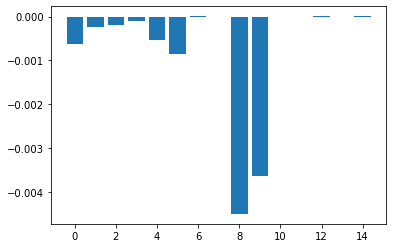

In [31]:
feat_imp = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(feat_imp):
    #print('%s, feature_score: %.5f' % (X_test.columns[i],v))
    print(X_test.columns[i],'\t',v)
# plot feature importance
plt.bar([x for x in range(len(feat_imp))], feat_imp)
plt.show()

* k nearest neighbors classifier

In [32]:
clf = KNeighborsClassifier(n_neighbors=100)
clf.fit(X_train, y_train)
mdf_knn_p=clf.predict(X_test)

In [33]:
#print(clf.score(X_test, y_test))
print('LR Accuracy score= ', metrics.accuracy_score(mdf_knn_p, y_test))
print('LR MAE = ', metrics.mean_absolute_error(mdf_knn_p, y_test))

LR Accuracy score=  0.7904080672492828
LR MAE =  0.20959193275071716


5. **Perform modeling at the aggregated state/YrMonth level**

* Train and split the data

In [35]:
masterdfagg.head()
masterdfagg.shape

X_trainagg, X_testagg, y_trainagg, y_testagg = train_test_split(
    masterdfagg.loc[:, masterdfagg.columns[~masterdfagg.columns.isin(['YEARMONTH','STATE_C','ANXWORRYDWN','ANXWORRYDWN_NUM','Work_Private','people_vaccinated_per_hundred','Work_NonProfit'])]], 
    masterdfagg['ANXWORRYDWN_NUM'], 
    test_size=0.25, random_state=42)

print(X_trainagg.shape)
print(X_testagg.shape)


(688, 12)
(230, 12)


In [36]:
print(masterdfagg['ANXWORRYDWN_NUM'].min(), masterdfagg['ANXWORRYDWN_NUM'].max())
print(masterdfagg['ANXWORRYDWN'].min(), masterdfagg['ANXWORRYDWN'].max())
masterdfagg.head()

4.4288256227758005 6.4871428571428575
0.0960591133004926 0.3352380952380952


,YEARMONTH,STATE_C,TBIRTH_YEAR,EEDUC,WRKLOSS,MORTLMTH,MORTCONF,INCOME,REMPCT,CDCCOUNT,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,ANXWORRYDWN_NUM,ANXWORRYDWN,Work_Government,Work_Private,Work_NonProfit,Work_SelfEmp,Work_FamilyBiz
0,2020-10,AK,1973.985961,5.468683,1.647948,0.955724,3.663067,5.481641,0.090,9349.0,0.0,0.0,5.748380,0.247300,0.293737,0.424406,0.139309,0.120950,0.021598
1,2020-10,AL,1971.887850,5.644860,1.684579,0.918224,3.593458,5.182243,0.043,37989.0,0.0,0.0,5.189252,0.179907,0.221963,0.518692,0.107477,0.130841,0.021028
2,2020-10,AR,1972.555556,5.503268,1.657952,0.928105,3.590414,5.104575,0.054,22669.0,0.0,0.0,5.629630,0.226580,0.209150,0.507625,0.135076,0.128540,0.019608
3,2020-10,AZ,1971.155885,5.520679,1.662778,0.928950,3.686108,5.370095,0.106,33382.0,0.0,0.0,5.565217,0.227996,0.152704,0.603393,0.095440,0.130435,0.018028
4,2020-10,CA,1971.359348,5.879074,1.622642,0.945111,3.733276,6.218268,0.129,123849.0,0.0,0.0,5.673671,0.218696,0.210978,0.529588,0.114494,0.126072,0.018868


* XGBoost regressor

[0]	validation_0-rmse:4.44840	validation_1-rmse:4.48396
[1]	validation_0-rmse:4.00632	validation_1-rmse:4.03998
[2]	validation_0-rmse:3.60847	validation_1-rmse:3.63990
[3]	validation_0-rmse:3.25046	validation_1-rmse:3.28030
[4]	validation_0-rmse:2.92834	validation_1-rmse:2.95633
[5]	validation_0-rmse:2.63854	validation_1-rmse:2.66515
[6]	validation_0-rmse:2.37783	validation_1-rmse:2.40074
[7]	validation_0-rmse:2.14334	validation_1-rmse:2.16510
[8]	validation_0-rmse:1.93247	validation_1-rmse:1.95108
[9]	validation_0-rmse:1.74292	validation_1-rmse:1.76053
[10]	validation_0-rmse:1.57250	validation_1-rmse:1.58888
[11]	validation_0-rmse:1.41938	validation_1-rmse:1.43312
[12]	validation_0-rmse:1.28177	validation_1-rmse:1.29517
[13]	validation_0-rmse:1.15811	validation_1-rmse:1.16966
[14]	validation_0-rmse:1.04717	validation_1-rmse:1.05663
[15]	validation_0-rmse:0.94762	validation_1-rmse:0.95640
[16]	validation_0-rmse:0.85810	validation_1-rmse:0.86683
[17]	validation_0-rmse:0.77779	validation

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

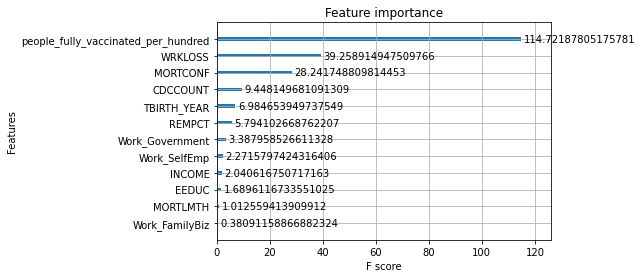

In [37]:
mdfagg_xg =XGBRegressor(n_estimators=30,learning_rate=0.1) #optimize?
mdfagg_xg.fit(X_trainagg, y_trainagg, eval_set=[(X_trainagg, y_trainagg),(X_testagg, y_testagg)], early_stopping_rounds=10, verbose=True)
print(mdfagg_xg.score(X_testagg, y_testagg))
#print(mdf_mlm_xg.evals_result())
feature_importance=mdfagg_xg.feature_importances_
feature_imp_pd=pd.DataFrame(feature_importance)
print(feature_imp_pd.sort_values(0, ascending=False))

#importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgg=mdfagg_xg.get_booster().get_score(importance_type='total_gain')
print(xgg)

xgb.plot_importance(mdfagg_xg,importance_type='total_gain') # jz


<class 'numpy.ndarray'>
XG MAE =  0.24008284960186774
XG RMSE =  0.08557602832309255
XG R2_score=  0.37158247855324833


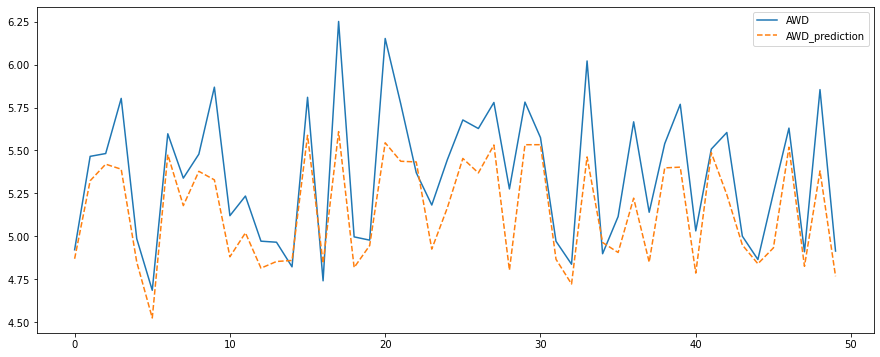

In [38]:
# run prediction and evaluate metrics
mdfagg_xg_p = mdfagg_xg.predict(X_testagg)
print(type(mdfagg_xg_p))

#print('XG Accuracy score = ', metrics.accuracy_score(mdfagg_xg_p, y_testagg))
print('XG MAE = ', metrics.mean_absolute_error(mdfagg_xg_p, y_testagg))
print('XG RMSE = ', metrics.mean_squared_error(mdfagg_xg_p, y_testagg, squared=True))
print('XG R2_score= ', metrics.r2_score(y_testagg,mdfagg_xg_p))

yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_xg_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:50], label = "AWD", linestyle="-")
plt.plot(ypredict[0:50], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()

* MLP Regressor model

In [39]:
clf = MLPRegressor(hidden_layer_sizes=(15,14,12,11,10,9,8,7,6,5,4),random_state=1, max_iter=20000)
clf.fit(X_trainagg, y_trainagg)
mdfagg_ml_p=clf.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('MLP MAE = ', metrics.mean_absolute_error(mdfagg_ml_p, y_testagg))
print('MLP RMSE = ', metrics.mean_squared_error(mdfagg_ml_p, y_testagg, squared=True))
print('MLP r2_score ', metrics.r2_score(y_testagg,mdfagg_ml_p))

MLP MAE =  0.3449793245276098
MLP RMSE =  0.1615381563623871
MLP r2_score  -0.1862364943727577


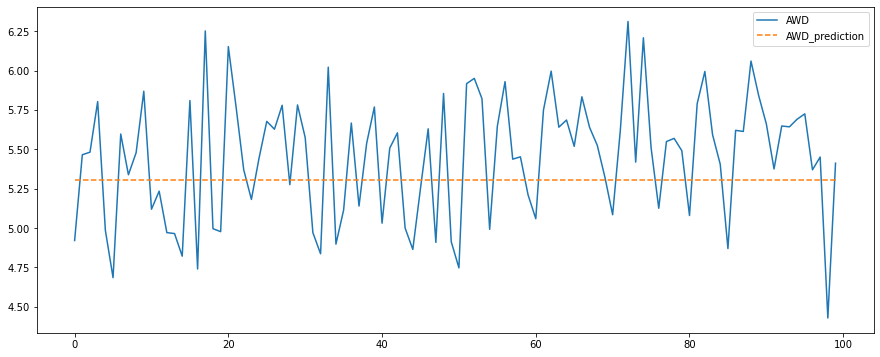

In [40]:
yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_ml_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:100], label = "AWD", linestyle="-")
plt.plot(ypredict[0:100], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.show()

* **regression models**

* linear regression

In [41]:
reg = linear_model.LinearRegression()
reg.fit(X_trainagg, y_trainagg)
reg.coef_
reg.score(X_testagg, y_testagg)
mdfagg_lr_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('LinReg MAE = ', metrics.mean_absolute_error(mdfagg_lr_p, y_testagg))
print('LinReg RMSE = ', metrics.mean_squared_error(mdfagg_lr_p, y_testagg, squared=True))
print('LinReg r2= ', metrics.r2_score(y_testagg,mdfagg_lr_p))


LinReg MAE =  0.16626705005774295
LinReg RMSE =  0.04431297271097164
LinReg r2=  0.6745928851263145


* Dump the full dataset out to csv file

In [42]:
mdfaggact=masterdfagg[['YEARMONTH','STATE_C','ANXWORRYDWN_NUM']]

X_fullagg=masterdfagg.loc[:, masterdfagg.columns[~masterdfagg.columns.isin(['YEARMONTH','STATE_C','ANXWORRYDWN','ANXWORRYDWN_NUM','Work_Private','people_vaccinated_per_hundred','Work_NonProfit'])]] 
#print(X_fullagg.info())
Y_lr_p=pd.DataFrame(reg.predict(X_fullagg), columns=['ANXWORRYDWN_NUM_PRED'])
#print(mdfaggact.info())
#print(Y_lr_p.info())

fullagg=pd.concat([mdfaggact,Y_lr_p], axis=1)
#print(fullagg.info())
fullagg.to_csv('data//agg_full.csv', index=False)

* OLS

In [43]:
import statsmodels.api as sm
  
# defining the variables
x = X_trainagg
y = y_trainagg
  
# adding the constant term
x = sm.add_constant(x)
  
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
  
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        ANXWORRYDWN_NUM   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     121.4
Date:                Tue, 30 Nov 2021   Prob (F-statistic):          1.52e-159
Time:                        21:37:59   Log-Likelihood:                 111.82
No. Observations:                 688   AIC:                            -197.6
Df Residuals:                     675   BIC:                            -138.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Feature: TBIRTH_YEAR, 	 Score: 0.06363152
Feature: EEDUC, 	 Score: 0.27765725
Feature: WRKLOSS, 	 Score: -2.17146933
Feature: MORTLMTH, 	 Score: 2.82864914
Feature: MORTCONF, 	 Score: -1.66098665
Feature: INCOME, 	 Score: 0.01440327
Feature: REMPCT, 	 Score: 0.09017274
Feature: CDCCOUNT, 	 Score: 0.00000040
Feature: people_fully_vaccinated_per_hundred, 	 Score: 0.00441223
Feature: Work_Government, 	 Score: 0.65710166
Feature: Work_SelfEmp, 	 Score: 1.54544632
Feature: Work_FamilyBiz, 	 Score: 0.36889990


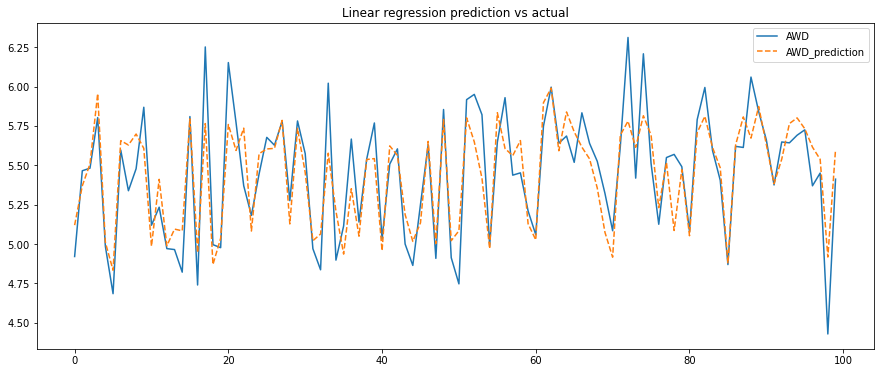

In [44]:
#print(reg.coef_)
for i,v in enumerate(reg.coef_):
    print('Feature: %s, \t Score: %.8f' % (X_trainagg.columns[i],v))

yt=pd.DataFrame(y_testagg.to_list())
#print(yt[0:5])

ypredict=pd.DataFrame(mdfagg_lr_p)
plt.figure(figsize=(15,6))
plt.plot(yt[0:100], label = "AWD", linestyle="-")
plt.plot(ypredict[0:100], label = "AWD_prediction", linestyle="--")
plt.legend()
plt.title("Linear regression prediction vs actual")
plt.show()

In [45]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X_trainagg)
X = scaler.transform(X_trainagg)# The PCA model
pca = PCA(n_components=2) # estimate only 2 PCs
pcafit = pca.fit(X)
X_new = pca.fit_transform(X) # project the original data into the PCA space

print(abs( pca.components_ ))
print(X_trainagg.columns)

# summarize components
print("Explained Variance: %s" % pcafit.explained_variance_ratio_)
print(pcafit.components_)

[[0.18947801 0.37645869 0.3598853  0.39545819 0.44686324 0.40073907
  0.06737036 0.03072081 0.36613621 0.01286259 0.05373169 0.18331114]
 [0.00816758 0.36006226 0.3223606  0.17791216 0.10318281 0.31830029
  0.54842685 0.15046715 0.33241327 0.16588872 0.24163112 0.32084572]]
Index(['TBIRTH_YEAR', 'EEDUC', 'WRKLOSS', 'MORTLMTH', 'MORTCONF', 'INCOME',
       'REMPCT', 'CDCCOUNT', 'people_fully_vaccinated_per_hundred',
       'Work_Government', 'Work_SelfEmp', 'Work_FamilyBiz'],
      dtype='object')
Explained Variance: [0.313367   0.19916707]
[[-0.18947801  0.37645869  0.3598853   0.39545819  0.44686324  0.40073907
   0.06737036  0.03072081  0.36613621  0.01286259  0.05373169 -0.18331114]
 [-0.00816758  0.36006226 -0.3223606  -0.17791216 -0.10318281  0.31830029
   0.54842685  0.15046715 -0.33241327  0.16588872 -0.24163112 -0.32084572]]


* Recursive feature elimination/ranking

In [46]:
from sklearn.feature_selection import RFE
estimator = linear_model.LinearRegression()
selector = RFE(estimator, n_features_to_select=2, step=1)
rfefit = selector.fit(X_trainagg, y_trainagg)
#print(selector.support_)
sel_rank=list(rfefit.ranking_)

print("Num Features: %d" % rfefit.n_features_)
print("Selected Features: %s" % rfefit.support_)
print("Feature Ranking: %s" % rfefit.ranking_)

for i in range(len(sel_rank)):
    print('feature:', X_trainagg.columns[i], '\t\t Ranking:', sel_rank[i])

Num Features: 2
Selected Features: [False False  True  True False False False False False False False False]
Feature Ranking: [ 9  5  1  1  2  8  3 11 10  6  4  7]
feature: TBIRTH_YEAR 		 Ranking: 9
feature: EEDUC 		 Ranking: 5
feature: WRKLOSS 		 Ranking: 1
feature: MORTLMTH 		 Ranking: 1
feature: MORTCONF 		 Ranking: 2
feature: INCOME 		 Ranking: 8
feature: REMPCT 		 Ranking: 3
feature: CDCCOUNT 		 Ranking: 11
feature: people_fully_vaccinated_per_hundred 		 Ranking: 10
feature: Work_Government 		 Ranking: 6
feature: Work_SelfEmp 		 Ranking: 4
feature: Work_FamilyBiz 		 Ranking: 7


* mutual information correlation

In [47]:
from sklearn.feature_selection import f_regression, mutual_info_regression

mi = mutual_info_regression(X_trainagg, y_trainagg)
print(mi)

for i in range(len(mi)):
    print('feature:', X_trainagg.columns[i], '\t\t MI score:', mi[i])

[0.         0.         0.39426836 0.12602274 0.24092568 0.0346428
 0.02734347 0.07130395 0.43618148 0.         0.         0.        ]
feature: TBIRTH_YEAR 		 MI score: 0.0
feature: EEDUC 		 MI score: 0.0
feature: WRKLOSS 		 MI score: 0.39426835919508996
feature: MORTLMTH 		 MI score: 0.1260227393853839
feature: MORTCONF 		 MI score: 0.240925675058846
feature: INCOME 		 MI score: 0.03464279681543836
feature: REMPCT 		 MI score: 0.027343473358024006
feature: CDCCOUNT 		 MI score: 0.07130394983901978
feature: people_fully_vaccinated_per_hundred 		 MI score: 0.43618148231460907
feature: Work_Government 		 MI score: 0.0
feature: Work_SelfEmp 		 MI score: 0.0
feature: Work_FamilyBiz 		 MI score: 0.0


*  ridge regression

In [48]:
reg = linear_model.Ridge(alpha=0.15)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_ridge_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('ridge MAE = ', metrics.mean_absolute_error(mdfagg_ridge_p, y_testagg))
print('ridge RMSE = ', metrics.mean_squared_error(mdfagg_ridge_p, y_testagg, squared=True))
print('ridge r2= ', metrics.r2_score(y_testagg,mdfagg_ridge_p))

[ 5.95179054e-02  2.55797720e-01 -2.00952295e+00  8.67518177e-01
 -1.20333838e+00  4.10014297e-03  5.74383593e-02  4.29400885e-07
  3.43475788e-03  5.61953645e-01  1.15152053e+00  1.14545297e-01]
ridge MAE =  0.16833372422737458
ridge RMSE =  0.04506509725142856
ridge r2=  0.669069746827015


* lasso reg   -- Result: performed poorly with average alpha, hence feature reduction is not feasible

In [49]:
reg = linear_model.Lasso(alpha=0.2)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_lasso_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('Lasso MAE = ', metrics.mean_absolute_error(mdfagg_lasso_p, y_testagg))
print('Lasso RMSE = ', metrics.mean_squared_error(mdfagg_lasso_p, y_testagg, squared=True))
print('Lasso r2= ', metrics.r2_score(y_testagg,mdfagg_lasso_p))

[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  6.27782987e-07
 -1.06903688e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Lasso MAE =  0.20111314489134682
Lasso RMSE =  0.06428049710461817
Lasso r2=  0.5279637129765145


* **lasso and lasso lars(AIC/BIC) cv**

Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


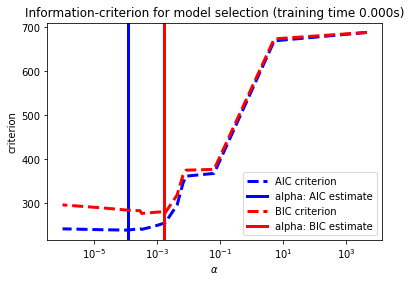

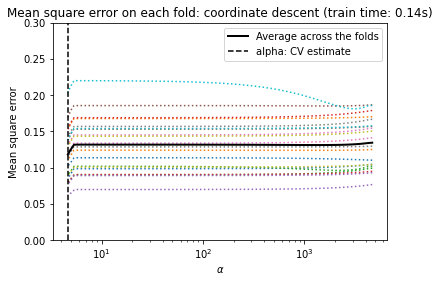

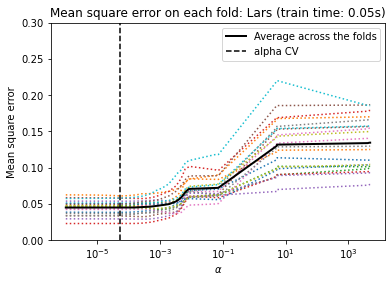

In [50]:
model_bic = linear_model.LassoLarsIC(criterion="bic", normalize=False)
t1 = time.time()
model_bic.fit(X_trainagg, y_trainagg)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = linear_model.LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X_trainagg, y_trainagg)
alpha_aic_ = model_aic.alpha_

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-6

def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")
plot_ic_criterion(model_bic, "BIC", "r")
plt.legend()
plt.title("Information-criterion for model selection (training time %.3fs)" % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = linear_model.LassoCV(cv=20).fit(X_trainagg, y_trainagg)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 0, 0.3
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold: coordinate descent (train time: %.2fs)"
    % t_lasso_cv
)
plt.axis("tight")
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = linear_model.LassoLarsCV(cv=20, normalize=False).fit(X_trainagg, y_trainagg)
t_lasso_lars_cv = time.time() - t1

# Display results
plt.figure()
plt.semilogx(model.cv_alphas_ + EPSILON, model.mse_path_, ":")
plt.semilogx(
    model.cv_alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(model.alpha_, linestyle="--", color="k", label="alpha CV")
plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold: Lars (train time: %.2fs)" % t_lasso_lars_cv)
plt.axis("tight")
plt.ylim(ymin, ymax)

plt.show()

* elasticnet

In [51]:
reg = linear_model.ElasticNet(alpha=0.001,l1_ratio=0.1)
reg.fit(X_trainagg, y_trainagg)
print(reg.coef_)
#reg.score(X_testagg, y_testagg)
mdfagg_lasso_p=reg.predict(X_testagg)
#clf.score(X_testagg, y_testagg)
print('ElasticNet MAE = ', metrics.mean_absolute_error(mdfagg_lasso_p, y_testagg))
print('ElasticNet RMSE = ', metrics.mean_squared_error(mdfagg_lasso_p, y_testagg, squared=True))
print('ElasticNet r2 = ', metrics.r2_score(y_testagg,mdfagg_lasso_p))

[ 5.02671564e-02  2.16047098e-01 -1.61271798e+00  4.57861373e-02
 -9.60802510e-01  3.66240593e-04  2.96863336e-02  4.73037690e-07
  9.64535538e-04  3.70537140e-01  5.27289540e-01  0.00000000e+00]
ElasticNet MAE =  0.1694395815969329
ElasticNet RMSE =  0.045772573321192125
ElasticNet r2 =  0.6638744793326512
